# One Attention Head Is All You Need for Sorting Fixed-Length Lists [working title]

(to justify that title, we may later need to replicate it on eg 100 element lists and bigger `d_vocab`)

Old title: Training a Transformer for Sorting Fixed-length Lists

This experiment was based on the [suggestion given by Neel Nanda](https://www.lesswrong.com/s/yivyHaCAmMJ3CqSyj/p/ejtFsvyhRkMofKAFy#Problems).

- Sorting fixed-length lists
  - `START 4 6 2 9 MID 2 4 6 9`
  - How does difficulty change with the length of the list?
  - A* Sorting variable-length lists.
    - What’s the sorting algorithm? What’s the longest list you can get to? How is accuracy affected by longer lists?

## TODO

- Find the point where model groks validation data
- See if it can grok it with smaller n of heads and/or dimensions (both d_head and d_model)
- Do interpretability on the smallest viable model and reap profit


## Setup

In [ ]:
!pip install numpy torch tqdm pandas plotly typing_extensions
!pip install git+https://github.com/neelnanda-io/TransformerLens

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/neelnanda-io/TransformerLens to /tmp/pip-req-build-ay0m7_re
  Running command git clone --filter=blob:none --quiet https://github.com/neelnanda-io/TransformerLens /tmp/pip-req-build-ay0m7_re
  Resolved https://github.com/neelnanda-io/TransformerLens to commit 090f63afcf72e8ecd9527bbb6f598874554def1b
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
from __future__ import annotations
from dataclasses import dataclass, field
from datetime import datetime as dt
from itertools import repeat
import os
import pickle
import random
from typing import cast, Generator, Literal

import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn, tensor, Tensor, TensorType as TT
from torch.nn import functional as F
from tqdm import tqdm
from transformer_lens import HookedTransformerConfig, HookedTransformer
from typing_extensions import Self

In [ ]:
%pip install circuitsvis
import circuitsvis as cv
# Testing that the library works
cv.examples.hello("Neel")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Hyperparams

In [ ]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"{DEVICE = }")

# Seeds to generate training, validation, and test data
TRAIN_SEED = 42
VAL_SEED = 66
TEST_SEED = 1729

# Fixed length of list to be sorted
LIST_LENGTH = 5
# Context length: [start, *(unsorted_)list_length, mid, *(sorted_)list_length]
N_CTX = 2 * LIST_LENGTH + 2

# Size of vocabulary
D_VOCAB = 66

# "Real" tokens range from 0 to D_VOCAB - 2 (non-inclusive)
VOCAB_MIN_ID = 0
VOCAB_MAX_ID = D_VOCAB - 2

# START token is D_VOCAB - 2 and MID token is D_VOCAB - 1
START_TOKEN_ID = VOCAB_MAX_ID
MID_TOKEN_ID = D_VOCAB - 1

# Should lists have repetitions?
ALLOW_REPETITIONS = True

DEVICE = 'cpu'


## Toy model for testing

In [ ]:
def make_toy_model() -> HookedTransformer:
    """Make a toy transformer for testing functions"""
    cfg = HookedTransformerConfig(
        n_layers=1,
        d_model=32,
        n_ctx=N_CTX,
        d_head=8,
        n_heads=1,
        d_vocab=D_VOCAB,
        act_fn="relu",
        device=DEVICE,
        attn_only=True
    )
    return HookedTransformer(cfg, move_to_device=True)

## Data generator and datasets

In [ ]:
def generate_list(batch_size: int) -> Tensor:
    if ALLOW_REPETITIONS:
        return torch.randint(VOCAB_MIN_ID, VOCAB_MAX_ID, (batch_size, LIST_LENGTH)).to(DEVICE)
    return tensor([
        random.sample(range(VOCAB_MIN_ID, VOCAB_MAX_ID), k=LIST_LENGTH) 
        for _ in range(batch_size)
    ]).to(DEVICE)

# General generator
def make_data_gen(
    *,
    batch_size: int = 32,
    dataset: Literal["train", "val", "test"], # probably this arg needs a better name,
) -> Generator[Tensor, None, None]:
    assert dataset in ("train", "val", "test")
    if dataset == "train":
        seed = TRAIN_SEED
    elif dataset == "val":
        seed = VAL_SEED
    else: # test
        seed = TEST_SEED
    torch.manual_seed(seed)
    while True:
        # Generate random numbers
        x = generate_list(batch_size)
        # Sort
        x_sorted = torch.sort(x, dim=1).values
        # START tokens
        x_start = START_TOKEN_ID * torch.ones(batch_size, dtype=torch.int32).reshape(batch_size, -1).to(DEVICE)
        # MID tokens
        x_mid = MID_TOKEN_ID * torch.ones(batch_size, dtype=torch.int32).reshape(batch_size, -1).to(DEVICE)
        yield torch.cat((x_start, x, x_mid, x_sorted), dim=1)


# Training data generator (kinda wrapper)
def make_train_gen() -> Generator[Tensor, None, None]:
    """Make generator of training data"""
    return make_data_gen(batch_size=128, dataset="train")

# Validation and test data

val_data = next(make_data_gen(batch_size=1000, dataset="val"))
test_data = next(make_data_gen(batch_size=1000, dataset="test"))
print(f"{val_data.shape=}; {test_data.shape=}")

val_data.shape=torch.Size([1000, 12]); test_data.shape=torch.Size([1000, 12])


In [ ]:
def has_repetition(l):
  return len(l.tolist()) != len(set(l.tolist()))

def make_data_gen_with_rep(
    *,
    batch_size: int = 32,
    dataset: Literal["train", "val", "test"], # probably this arg needs a better name,
) -> Generator[Tensor, None, None]:
    assert dataset in ("train", "val", "test")
    if dataset == "train":
        seed = TRAIN_SEED
    elif dataset == "val":
        seed = VAL_SEED
    else: # test
        seed = TEST_SEED
    torch.manual_seed(seed)
    data_gen = make_data_gen(batch_size = 1, dataset=dataset)
    while True:
      u = []
      for _ in range(batch_size):
        next_try = next(data_gen)
        while not has_repetition(next_try[0][1:LIST_LENGTH+1]):
          next_try = next(data_gen)
        u.append(next_try)

      yield torch.cat(u)

In [ ]:
l = torch.tensor([1,2,3,3]).tolist()
torch.tensor([l,l,l])

tensor([[1, 2, 3, 3],
        [1, 2, 3, 3],
        [1, 2, 3, 3]])

In [ ]:
d = make_data_gen_with_rep(batch_size=10, dataset="test")
next(d)

tensor([[64, 30,  1,  3,  1, 37, 65,  1,  1,  3, 30, 37],
        [64, 39, 51,  9, 26, 51, 65,  9, 26, 39, 51, 51],
        [64, 47, 16,  0, 45, 47, 65,  0, 16, 45, 47, 47],
        [64,  4, 25, 25, 38, 53, 65,  4, 25, 25, 38, 53],
        [64, 42, 57, 47, 55, 42, 65, 42, 42, 47, 55, 57],
        [64, 46, 47, 28, 28, 41, 65, 28, 28, 41, 46, 47],
        [64, 51, 31,  1, 31, 54, 65,  1, 31, 31, 51, 54],
        [64, 50, 57, 57,  8, 14, 65,  8, 14, 50, 57, 57],
        [64,  3, 62,  2, 57, 57, 65,  2,  3, 57, 57, 62],
        [64,  4,  4,  6, 62, 17, 65,  4,  4,  6, 17, 62]])

In [ ]:
# Test

toy_model = make_toy_model()
x = next(make_train_gen())
y = toy_model(x)
y.argmax(-1)[0], x[0]

(tensor([ 0, 10, 43, 17, 55, 27, 54, 43, 29,  0, 53, 54]),
 tensor([64, 38, 51, 28, 14, 42, 65, 14, 28, 38, 42, 51]))

## Loss function

In [ ]:
def loss_fn(
    logits: Tensor, # [batch, pos, d_vocab] 
    tokens: Tensor, # [batch, pos] 
    return_per_token: bool = False
) -> Tensor:
    #TODO: document what happens here
    sorted_start_pos = LIST_LENGTH + 2
    logits = logits[:, (sorted_start_pos-1):-1]
    # print(tokens[0])
    tokens = tokens[:, sorted_start_pos : None]
    # print(tokens[0], logits.shape,tokens.shape, logits.argmax(-1)[0])
    log_probs = logits.log_softmax(-1)
    correct_log_probs = log_probs.gather(-1, tokens[..., None])[..., 0]
    if return_per_token:
        return -correct_log_probs
    return -correct_log_probs.mean()

# Test

toy_model = make_toy_model()
x = next(make_train_gen())
gen = make_train_gen()
x = next(gen)
y = toy_model(x)
loss_fn(y, x)

tensor(4.4752, grad_fn=<NegBackward0>)

## Accuracy and validation

In [ ]:
def get_diff_row_inds(
    a: Tensor, # [dim1, dim2]
    b: Tensor  # [dim1, dim2]
) -> Tensor:   # [dim1]
    """Find indices of rows where a and b differ"""
    assert a.shape == b.shape
    return ((a == b).prod(dim=1) == 0).nonzero(as_tuple=True)[0]

def acc_fn(
    logits: Tensor, # [batch, pos, d_vocab]
    tokens: Tensor, # [batch, pos]
    per: Literal["token", "sequence"] = "sequence"
) -> float:
    """Compute accuracy as percentage of correct predictions"""
    sorted_start_pos = LIST_LENGTH + 2
    # Get logits of predictions for position
    logits = logits[:, (sorted_start_pos-1):-1]
    preds = logits.argmax(-1)
    tokens = tokens[:, sorted_start_pos:]
    if per == "sequence":
        return (preds == tokens).prod(dim=1).float().mean().item()
    return (preds == tokens).float().mean().item()

def validate(
    model: HookedTransformer, 
    data: Tensor # [batch, pos]
) -> float:
    """Test this model on `data`"""
    logits = model(data)
    acc = acc_fn(logits, tokens=data)
    return acc

def show_mispreds(
    model: HookedTransformer, 
    data: Tensor # [batch, pos]
) -> None:
    """Test this model on `data` and print mispredictions"""
    logits = model(data)
    sorted_start_pos = LIST_LENGTH + 2
    logits = logits[:, (sorted_start_pos-1):-1]
    tokens = data[:, sorted_start_pos:]
    preds = logits.argmax(-1)
    mispred_inds = get_diff_row_inds(tokens, preds)
    for i in mispred_inds:
        print(f"[{i}] {tokens[i].numpy().tolist()} | {preds[i].numpy().tolist()}")
    print(f"{len(mispred_inds)}/{len(preds)} ({len(mispred_inds) / len(preds) :.2%})")
    
# show_mispreds(toy_model, val_data[:10])    


# Test
#TODO:


## Model and config

In [ ]:
cfg = HookedTransformerConfig(
    d_model=128,
    n_layers=1,
    n_heads=1,
    d_head=32,
    n_ctx=N_CTX,
    d_vocab=D_VOCAB,
    act_fn="relu",
    seed=42,
    device=DEVICE,
    attn_only=True
)
model = HookedTransformer(cfg, move_to_device=True)

## Training setup

In [ ]:
# Number of epochs
n_epochs = 20000

# Optimization
lr = 1e-3
betas = (.9, .999)
optim = torch.optim.Adam(model.parameters(), lr=lr, betas=betas)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, "min", patience=10000)

# Training data generator
train_gen = make_train_gen()

## Training

In [ ]:
losses = []
train_accuracies = []
val_accuracies = []

def converged(val_accs: list[float], n_last: int = 10) -> bool:
    return cast(bool, (tensor(val_accs[-n_last:]) == 1).all().item())

for epoch in range(n_epochs):
    tokens = next(train_gen).to(device=DEVICE)
    logits = model(tokens)
    loss = loss_fn(logits, tokens)
    loss.backward()
    optim.step()
    optim.zero_grad()
    scheduler.step(loss)
    
    if epoch % 100 == 0:
        losses.append(loss.item())
        train_batch_acc = acc_fn(logits, tokens)
        val_acc = validate(model, val_data)
        val_loss = loss_fn(model(val_data), val_data)

        train_accuracies.append(train_batch_acc)
        val_accuracies.append(val_acc)
        print(
            f"Epoch {epoch}/{n_epochs} ({epoch / n_epochs:.0%}) : "
            f"loss = {loss.item():.4f}; {train_batch_acc=:.3%}; "
            f"{val_acc=:.3%}; lr={scheduler._last_lr[0]}" #type:ignore
        )
        # If last 10 recorded val_accuracies are 100%
        if converged(val_accuracies):
            print(f"\nAchieved consistent perfect validation accuracy after {epoch} epochs")
            break


Epoch 0/20000 (0%) : loss = 4.4764; train_batch_acc=0.000%; val_acc=0.000%; lr=0.001
Epoch 100/20000 (0%) : loss = 0.4194; train_batch_acc=53.906%; val_acc=53.000%; lr=0.001
Epoch 200/20000 (1%) : loss = 0.1928; train_batch_acc=72.656%; val_acc=78.800%; lr=0.001
Epoch 300/20000 (2%) : loss = 0.1562; train_batch_acc=83.594%; val_acc=85.600%; lr=0.001
Epoch 400/20000 (2%) : loss = 0.1257; train_batch_acc=85.938%; val_acc=86.200%; lr=0.001
Epoch 500/20000 (2%) : loss = 0.1202; train_batch_acc=87.500%; val_acc=88.100%; lr=0.001
Epoch 600/20000 (3%) : loss = 0.0971; train_batch_acc=88.281%; val_acc=90.200%; lr=0.001
Epoch 700/20000 (4%) : loss = 0.0720; train_batch_acc=92.188%; val_acc=88.800%; lr=0.001
Epoch 800/20000 (4%) : loss = 0.0695; train_batch_acc=92.969%; val_acc=90.500%; lr=0.001
Epoch 900/20000 (4%) : loss = 0.0749; train_batch_acc=90.625%; val_acc=90.500%; lr=0.001
Epoch 1000/20000 (5%) : loss = 0.0514; train_batch_acc=92.188%; val_acc=90.200%; lr=0.001
Epoch 1100/20000 (6%) : 

## Testing post-training

In [ ]:
print("Validating on validation data:")
val_acc = validate(model, val_data)
print(f"\t{val_acc=:.3%}\n")
if val_acc < 1:
    show_mispreds(model, val_data)

print("\nValidating on test data:")
test_acc = validate(model, test_data)
print(f"\t{test_acc=:.3%}\n")
if test_acc < 1:
    show_mispreds(model, test_data)

Validating on validation data:
	val_acc=98.900%

[2] [10, 13, 13, 16, 39] | [10, 13, 16, 16, 39]
[12] [7, 30, 30, 42, 53] | [7, 30, 42, 42, 53]
[104] [8, 11, 61, 62, 63] | [8, 11, 60, 62, 63]
[171] [1, 21, 23, 23, 25] | [1, 21, 23, 25, 25]
[210] [20, 24, 24, 41, 42] | [20, 24, 41, 41, 42]
[260] [17, 17, 17, 18, 23] | [17, 17, 17, 17, 23]
[592] [22, 22, 29, 56, 62] | [22, 22, 22, 56, 62]
[657] [10, 10, 12, 19, 22] | [10, 12, 12, 19, 22]
[845] [2, 14, 14, 18, 19] | [2, 14, 18, 18, 19]
[912] [17, 17, 19, 32, 57] | [17, 17, 17, 32, 57]
[978] [2, 3, 3, 29, 57] | [2, 3, 2, 29, 57]
11/1000 (1.10%)

Validating on test data:
	test_acc=99.000%

[37] [42, 42, 47, 55, 57] | [42, 42, 42, 55, 57]
[464] [3, 16, 16, 18, 55] | [3, 16, 18, 18, 55]
[489] [24, 24, 27, 47, 53] | [24, 24, 24, 47, 53]
[531] [0, 0, 2, 28, 55] | [0, 2, 2, 28, 55]
[597] [5, 5, 6, 13, 22] | [5, 6, 6, 13, 22]
[693] [17, 31, 31, 36, 59] | [17, 31, 36, 36, 59]
[852] [24, 24, 29, 45, 59] | [24, 24, 24, 45, 59]
[891] [30, 30, 35, 37,

In [ ]:
other_tests = next(train_gen)
predictions = model(other_tests).argmax(dim=-1)[:,LIST_LENGTH+1:-1]

In [ ]:
for x,y in zip(other_tests, predictions):
  incorrect = (x[LIST_LENGTH+2:] != y).prod()
  print(f"{x} | {y}{' Incorrect!' if incorrect else ''}")

tensor([64, 39, 37, 15, 10, 46, 65, 10, 15, 37, 39, 46]) | tensor([10, 15, 37, 39, 46])
tensor([64, 51, 27, 55,  5, 52, 65,  5, 27, 51, 52, 55]) | tensor([ 5, 27, 51, 52, 55])
tensor([64,  8, 51, 40, 47, 18, 65,  8, 18, 40, 47, 51]) | tensor([ 8, 18, 40, 47, 51])
tensor([64, 18, 48,  5, 39,  0, 65,  0,  5, 18, 39, 48]) | tensor([ 0,  5, 18, 39, 48])
tensor([64, 27, 10, 47,  6, 27, 65,  6, 10, 27, 27, 47]) | tensor([ 6, 10, 27, 27, 47])
tensor([64, 14, 58, 35, 40, 35, 65, 14, 35, 35, 40, 58]) | tensor([14, 35, 35, 40, 58])
tensor([64, 20, 12, 25, 44, 25, 65, 12, 20, 25, 25, 44]) | tensor([12, 20, 25, 25, 44])
tensor([64,  2,  0, 46, 45, 13, 65,  0,  2, 13, 45, 46]) | tensor([ 0,  2, 13, 45, 46])
tensor([64, 42, 44,  0, 23, 28, 65,  0, 23, 28, 42, 44]) | tensor([ 0, 23, 28, 42, 44])
tensor([64, 22, 47, 19, 32, 55, 65, 19, 22, 32, 47, 55]) | tensor([19, 22, 32, 47, 55])
tensor([64, 54, 57, 62, 35, 23, 65, 23, 35, 54, 57, 62]) | tensor([23, 35, 54, 57, 62])
tensor([64, 26, 42,  2,  0, 33, 

## Saving trained model

In [ ]:
def make_timestamp() -> str:
    return dt.now().isoformat("T", "minutes").replace(":", "-")

if not os.path.isdir("models"):
    os.mkdir("models")

fname = f"model_state_dict_{make_timestamp()}.pkl"

with open("models/" + fname, "wb") as f:
    pickle.dump(model.state_dict(), f)

## Interior of the model

In [ ]:
def observing_test(list_to_order: list[int]):
  input = tensor([64] + list_to_order + [65] + sorted(list_to_order))
  logits, cache_model = model.run_with_cache(input, remove_batch_dim=True) 
  preds = logits[:,LIST_LENGTH+1:-1].argmax(-1)[0]
  attention_pattern = cache_model["pattern", 0, "attn"]
  tokens_input = list(map(str,list(input)))
  print(str(list_to_order) + " -> " + str(sorted(list_to_order)))
  print("prediction: ", preds.tolist())
  print("Correct" if (preds.tolist() == sorted(list_to_order)) else "Incorrect")
  return tokens_input, attention_pattern

In [ ]:
tok, att = observing_test([5, 1, 2, 5, 50])
cv.attention.attention_patterns(tokens=tok, attention=att)

[5, 1, 2, 5, 50] -> [1, 2, 5, 5, 50]
prediction:  [1, 2, 5, 5, 50]
Correct


In [ ]:
tok, att = observing_test([30, 30, 3, 2, 1])
cv.attention.attention_patterns(tokens=tok, attention=att)

[30, 30, 3, 2, 1] -> [1, 2, 3, 30, 30]
prediction:  [1, 2, 3, 30, 30]
Correct


In [ ]:
tok, att = observing_test([1, 1, 2, 1, 1])
cv.attention.attention_patterns(tokens=tok, attention=att)

[1, 1, 2, 1, 1] -> [1, 1, 1, 1, 2]
prediction:  [1, 1, 1, 1, 2]
Correct


In [ ]:
tok, att = observing_test([60, 50, 50, 50, 50])
cv.attention.attention_patterns(tokens=tok, attention=att)

[60, 50, 50, 50, 50] -> [50, 50, 50, 50, 60]
prediction:  [50, 50, 50, 50, 60]
Correct


In [ ]:
attn = model.blocks[0].attn
embedding_numbers = model.embed(tensor(list(range(66))))
matrix_key = attn.W_K
matrix_query = attn.W_Q
keys_numbers = embedding_numbers @ matrix_key
queries_numbers = embedding_numbers @ matrix_query

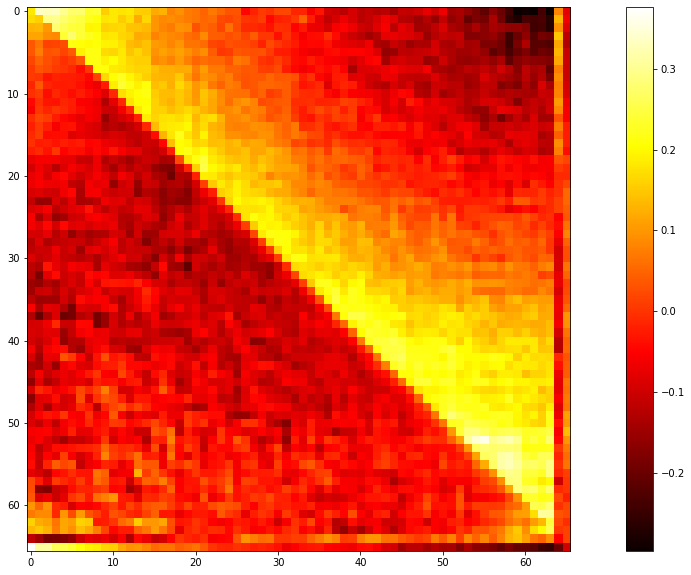

In [ ]:
plt.rcParams['figure.figsize'] = [20, 10]
attention_between_numbers = torch.einsum("ijr,ikr->ijk", queries_numbers, keys_numbers).detach().numpy()[0]
heatmap = plt.imshow(attention_between_numbers, cmap='hot', interpolation='nearest')
plt.colorbar(heatmap)
plt.show()

In [ ]:
mean_diag = attention_between_numbers.diagonal().mean()
mean_absolute_diag = np.absolute(attention_between_numbers.diagonal()).mean()
print("Mean value on the diagonal: ", mean_diag)
print("Mean absolute value on the diagonal: ", mean_absolute_diag)

Mean value on the diagonal:  0.043144636
Mean absolute value on the diagonal:  0.055903777
